## Import libraries

In [128]:
from PIL import Image, ImageOps
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
import glob
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import validation_curve
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
random =  400

### Check Number of Samples and Distribution of Classes

total number of images 7365
total number of infected images 1834
total number of uninfected images 5531


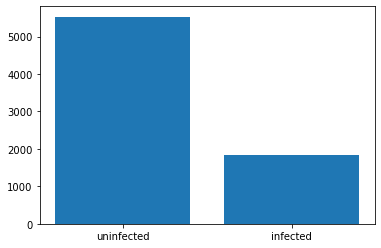

In [129]:
#Load filename from uah and uab_curated directory
infected_uab = glob.glob('dataset/malaria/uab_curated/1/*.png')
uninfected_uab = glob.glob('dataset/malaria/uab_curated/0/*.png')
infected_uah = glob.glob('dataset/malaria/uah/1/*.png')
uninfected_uah = glob.glob('dataset/malaria/uah/0/*.tiff')

# Get total number of sample for infected and uninfected images
infected_images =  infected_uab +infected_uah
uninfected_images =  uninfected_uab + uninfected_uah
total_infected = len(infected_images)
total_uninfected = len(uninfected_images)

print('total number of images', total_infected + total_uninfected)
print('total number of infected images', total_infected)
print('total number of uninfected images', total_uninfected)

# plt distribution of classes
plt.bar(['uninfected','infected'],[total_uninfected, total_infected])
plt.show()

## Visualize data and Check images

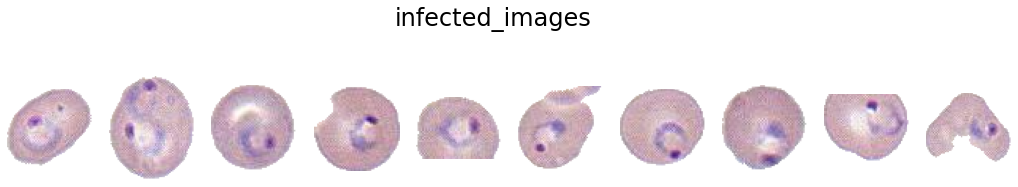

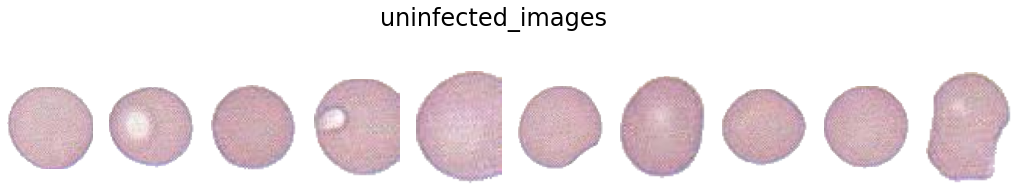

In [130]:
def plot_images(title,images):
    '''
    Function to plot images
    '''
    fig, ax = plt.subplots(figsize=(18, 8))
    fig.suptitle(title, fontsize=24)
    for ind, img_src in enumerate(images):
        plt.subplot(3, 10, ind+1)
        img = plt.imread(img_src)
        plt.axis('off')
        plt.imshow(img)

plot_images('infected_images', infected_images[:10])
plot_images('uninfected_images', uninfected_uah[:10])

## Preprocessing

In [131]:
def load_data():
    '''
    load the images as numpy array and resize the data into 64x64 resolution
    '''
    images = []
    labels = []
    # loaded uninfected images
    for file in uninfected_images:
        with Image.open(file) as img:
            np_img = np.array(img.resize((64,64)))
        images.append(np_img)
        labels.append(0)
    
    # loaded infected images
    for file in infected_images:
        with Image.open(file) as img:
            np_img = np.array(img.resize((64,64)))
        images.append(np_img)
        labels.append(1)
    
    imgs = np.asarray(images)
    lbls = np.asarray(labels)
    return imgs , lbls

images, labels= load_data()       

#### Reshape images into vector

In [132]:
# Get no of samples, height, width and channel information
n_samples, h,w,c = images.shape
# Reshape images to vector
x = images.reshape(n_samples,-1)
x.shape

(7365, 12288)

#### Split data into train and test set

In [133]:
X_train, X_test, y_train, y_test = train_test_split(
    x, labels, test_size=0.25, random_state=random
)

#### Standardize the data

In [ ]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


#### Apply PCA to reduce dimensions

In [7]:
pca  = PCA(n_components=0.95).fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

In [134]:
X_train_pca.shape

(5523, 765)

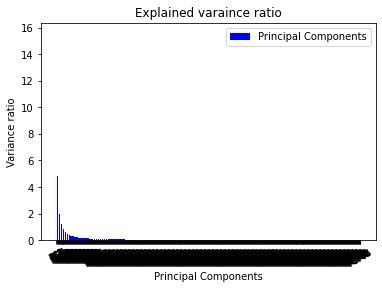

In [135]:
def plot_evr(ev,title):
    plt.figure()
    nums = [i+1 for i in range(len(ev))]
    plt.bar(nums,list(ev*100),label = 'Principal Components', color = 'b')
    plt.legend()
    plt.xlabel('Principal Components')
    pc = []

    for i in range(len(ev)):
        pc.append('PC'+str(i+1))
    plt.xticks(nums, pc, fontsize=8, rotation=30)
    plt.ylabel('Variance ratio')
    plt.title(title)
    plt.show()

plot_evr(pca.explained_variance_ratio_,"Explained varaince ratio")

### Plot Eigen cell

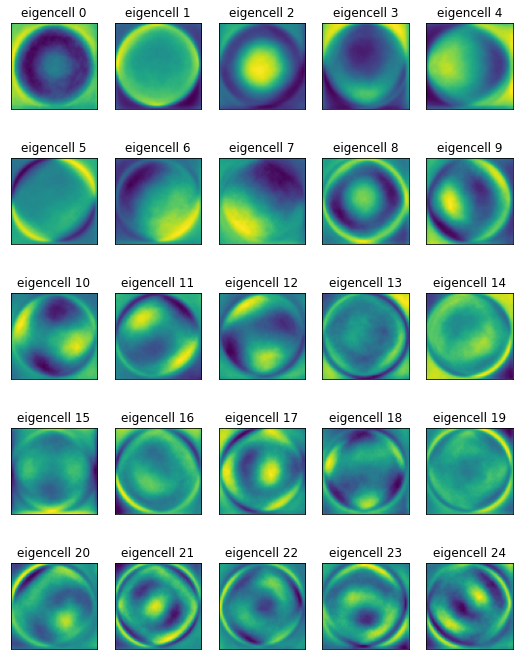

In [136]:
def plot_gallery(images, titles, h, w, n_row=5, n_col=5):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w, c))[:,:,1])
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

principal_components =  X_train_pca.shape[1]
eigencells  =  pca.components_.reshape((principal_components,h,w,c))
pca_titles = ["eigencell %d" % i for i in range(eigencells.shape[0])]
plot_gallery(eigencells,pca_titles,h,w)


### Learning Curves and Validation Curves

In [137]:
# Define pipeline for training
clf =  make_pipeline(StandardScaler(),PCA(n_components=0.95),SVC(kernel = 'rbf',class_weight='balanced'))

In [21]:
def plot_validation_curve(param_range, train_scores,  test_scores,xlabel):
    '''Function to plot cross validation scores
    '''
    train_mean = np.mean(train_scores,axis=1)
    test_mean = np.mean(test_scores, axis=1)
    train_std = np.std(train_scores,axis=1)
    test_std = np.std(test_scores,axis=1)

    plt.plot(param_range, train_mean, color='blue', marker='o', markersize=5,label='Training accuracy')
    plt.plot(param_range, test_mean, color='green', marker='s', linestyle='--', markersize=5,label='Test accuracy')
    plt.fill_between(param_range, train_mean+train_std, train_mean-train_std, alpha=0.15, color='blue')
    plt.fill_between(param_range,test_mean+test_std,test_mean-test_std, alpha=0.15, color='blue')

    plt.xlabel(xlabel)
    plt.ylabel('Accuracy')
    plt.legend(loc='best')
    plt.show()


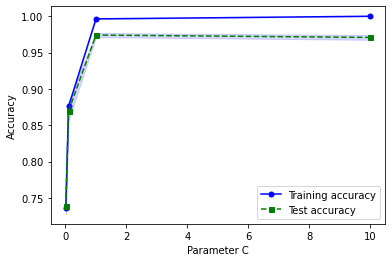

In [22]:
# Do 5 fold cross validation for parameter C
C_range =  [ 0.01, 0.1, 1.0, 10.0]
train_scores, test_scores =  validation_curve(estimator = clf, X = X_train, y = y_train, param_name = 'svc__C', param_range=C_range)
plot_validation_curve(param_range=C_range, train_scores=train_scores, test_scores=test_scores, xlabel='Parameter C')


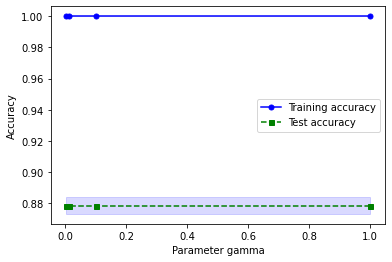

In [24]:
# Do 5 fold cross validation for parameter gamma
gamma_range =  gamma_range = [1, 0.1, 0.01, 0.001]
train_scores, test_scores =  validation_curve(estimator = clf, X = X_train, y = y_train, param_name = 'svc__gamma', param_range=gamma_range)
plot_validation_curve(param_range=gamma_range, train_scores=train_scores, test_scores=test_scores, xlabel='Parameter gamma')


### Fine Tuning Hyper Parameters with GridSearch

In [18]:
param_grid = {'svc__C':[0.1, 1]
            }
grid = GridSearchCV(clf,param_grid)
grid.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('pca', PCA(n_components=0.95)),
                                       ('svc', SVC(class_weight='balanced'))]),
             param_grid={'svc__C': [0.1, 1]})

In [138]:
print(grid.best_params_)
print(grid.best_estimator_)

{'svc__C': 1}
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('pca', PCA(n_components=0.95)),
                ('svc', SVC(C=1, class_weight='balanced'))])


### Classification Report And Confusion Matrix

In [139]:
predictions = grid.predict(X_test)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1398
           1       0.97      0.95      0.96       444

    accuracy                           0.98      1842
   macro avg       0.98      0.97      0.97      1842
weighted avg       0.98      0.98      0.98      1842



In [140]:
print("accuracy of model is",grid.score(X_test, y_test))

accuracy of model is 0.9815418023887079


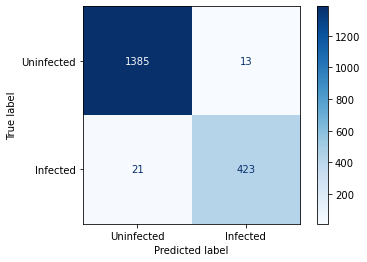

In [141]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Uninfected','Infected'])
disp.plot(cmap =plt.cm.Blues)
